# LLM Inference 

Large Language Model (LLM) inference presents unique challenges due to the complexity of the models and the computational demands of generating responses. Optimizing LLM performance involves balancing factors such as sequence length, model size, and specific use case requirements, with no one-size-fits-all solution for efficient inference across diverse applications.

Lets take a look at what are we working with here:

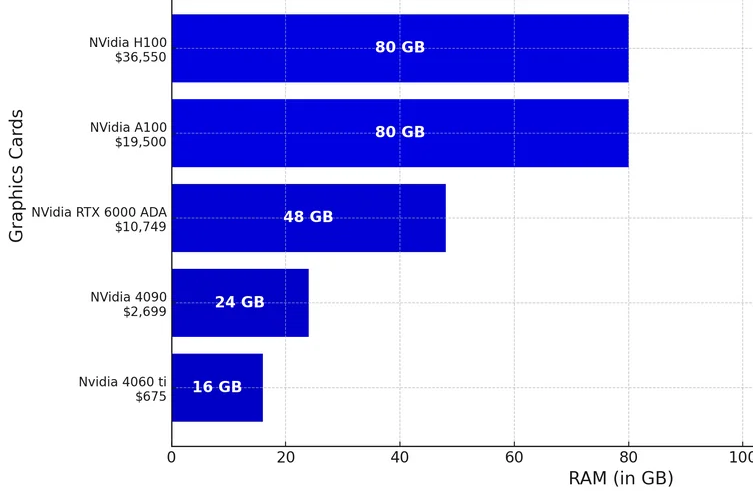

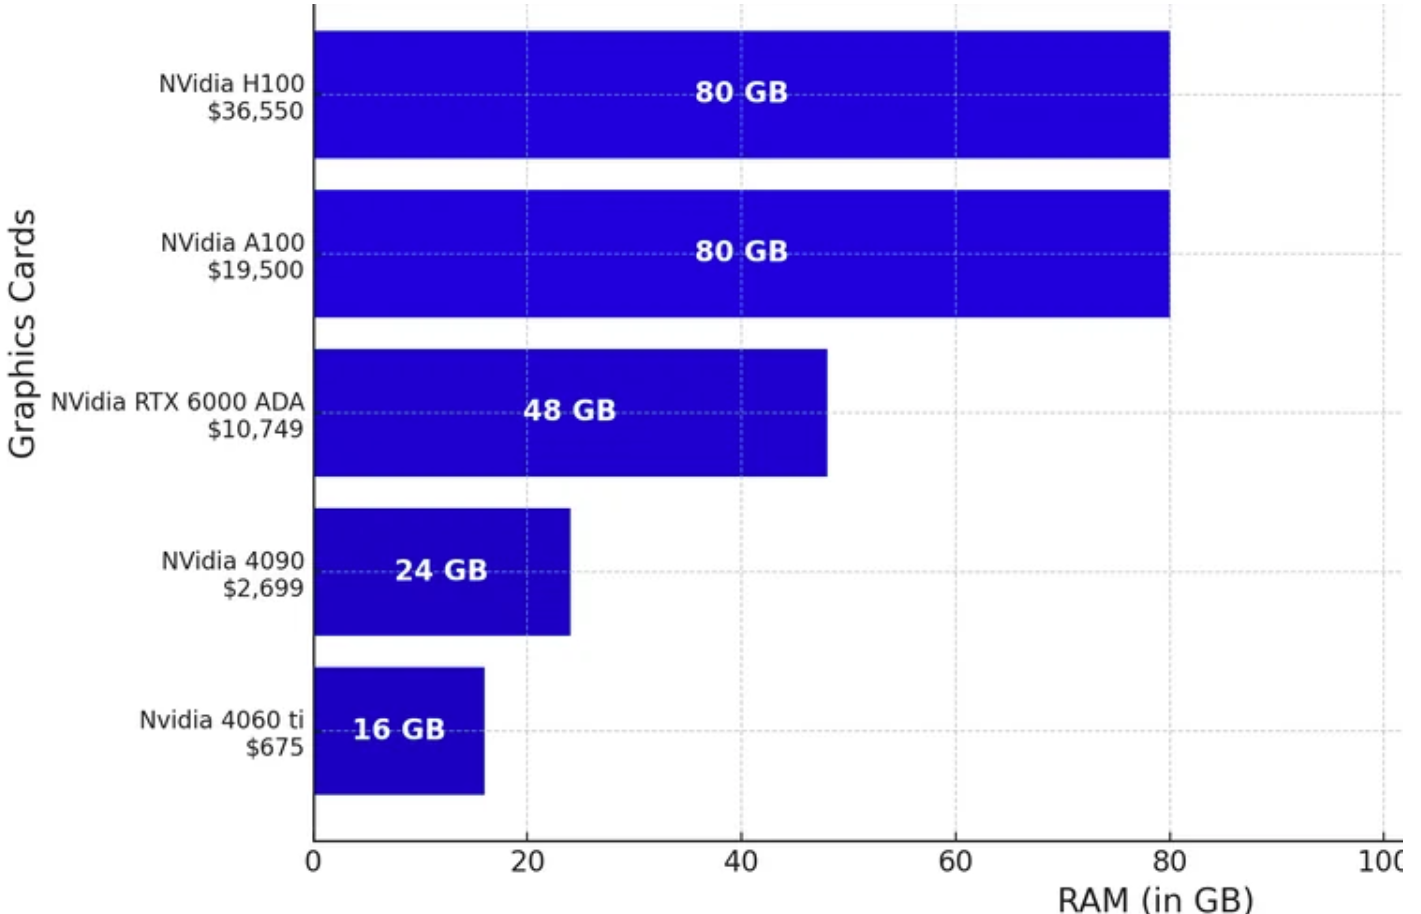

The size of an LLM significantly impacts its inference performance and resource requirements. Larger models with billions of parameters, such as GPT-4 with an estimated 1.7 trillion parameters, demand substantial memory and computational power. For instance, deploying GPT-4 using Nvidia H100 GPUs would require approximately 40 GPUs just to store the model parameters. This memory requirement increases further when accounting for key-value caches, which grow linearly with batch size.

- Larger models generally offer improved capabilities but at the cost of increased inference complexity and resource demands.
- Model size affects both memory usage and computational requirements, influencing factors such as latency, throughput, and deployment costs.
- Techniques like quantization, pruning, and knowledge distillation are being explored to reduce model size while maintaining performance, enabling more efficient inference on resource-constrained devices

At batch_size of 1, the KV cache memory is a small percentage of total memory.
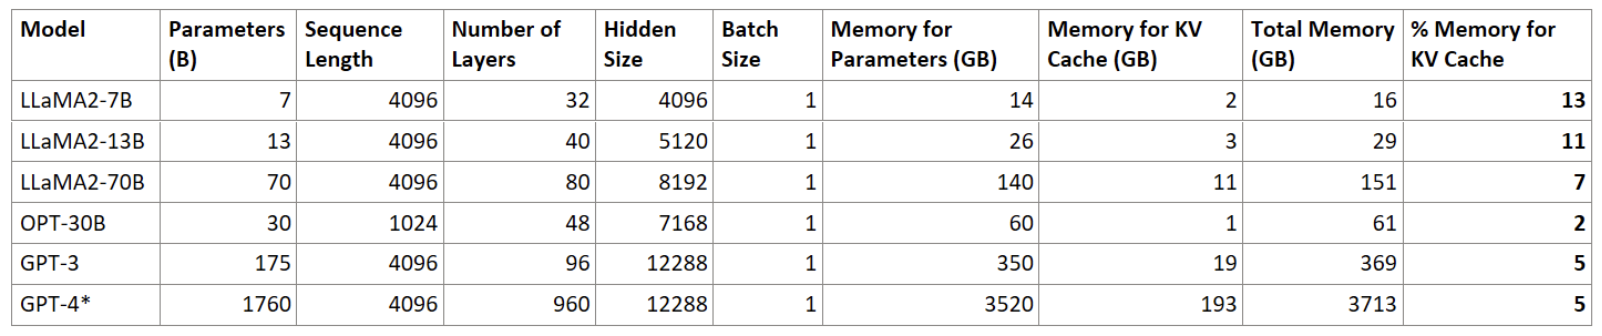

At a batch size of 32, static allocation of KV cache dominates the total memory
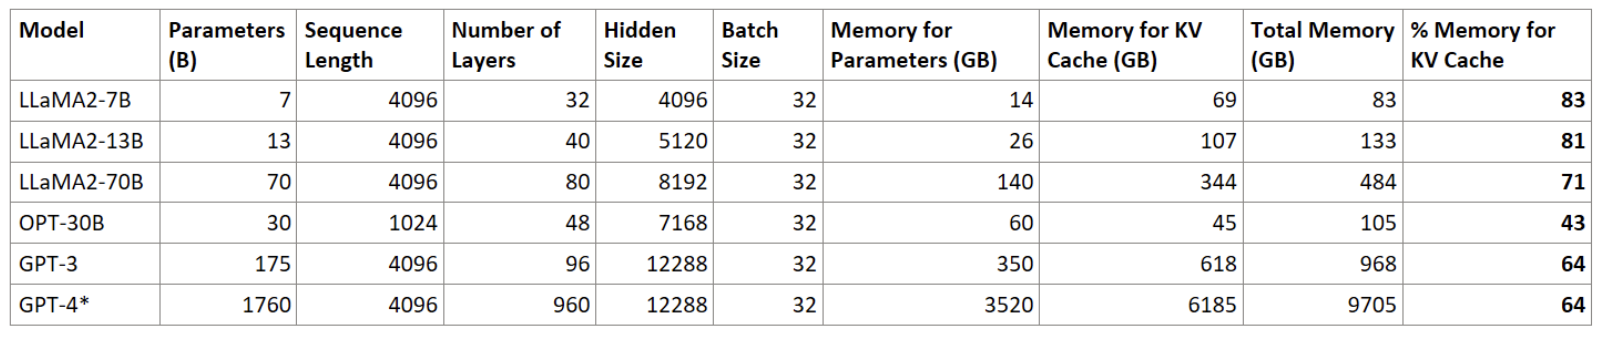

Total size of KV cache in bytes = (batch_size) x 2 x (sequence_length) x (num_layers) x (hidden_size) x SizeOf(FP16)

The sequence_length is the maximum number of tokens (sum of input and output tokens) allowed per user request for the model. Factor 2 is for each key and value in the KV pair. These are usually stored in 16-bit precision format (2Bytes each). num_layer is the number of transformer attention layers. The hidden_size is the dimension of the model-specific attention layer.

Inference metrics for Large Language Models (LLMs) are crucial for evaluating and optimizing performance. Key metrics include:

 - **Time to First Token (TTFT)**: Measures responsiveness, indicating how quickly the model generates its first output token after receiving a prompt
- **Time Per Output Token (TPOT)**: Reflects the model's generation speed, typically measured in milliseconds per token
-   **Throughput**: Quantifies the number of output tokens generated per second across all users and requests
-   **Latency**: The overall time to generate a full response, calculated as TTFT + (TPOT * number of tokens generated)

# Inference with vLLM

vLLM (Virtual Large Language Model) is an open-source library designed to optimize LLM inference and serving. Its key features include:

-   PagedAttention: A novel attention algorithm that efficiently manages memory by partitioning the KV cache into blocks, reducing fragmentation and enabling near-optimal memory usage
-   Continuous batching: Dynamically adjusts batch sizes to maximize throughput and reduce latency.
-   Optimized CUDA kernels: Custom implementations for key operations, enhancing performance on GPU hardware.
-   Tensor parallelism and pipeline parallelism: Supports distributed inference across multiple devices.
-   OpenAI-compatible API: Facilitates easy integration with existing applications.
-   Quantization support: Includes GPTQ, AWQ, INT4, INT8, and FP8 quantization techniques to reduce model size and memory requirements

These features collectively enable vLLM to achieve significantly higher throughput compared to other LLM serving solutions, making it a powerful tool for efficient and scalable LLM deployment

## Paged Attention in vLLM

![blog.runpod.io](https://lh7-us.googleusercontent.com/docsz/AD_4nXdJZ_p3OUnUQ1YtSTNef6iqMMGcHlntOzJCE_-ZlSfEfPqXet_EWJNFK7Hcpd9xDKBOqaOOmCNUCECCAmLfPidlEAhkCDjdWMImNaOL9tXvs6DgiH61ym2v-qSu3MpggyCXabhaB4UQGvNcapdSW9mHuy2k?key=jULPpW3gOjPzXuxrraGiJA)


Paged Attention, implemented in the vLLM library, is a novel technique that dramatically improves memory efficiency for large language model (LLM) inference. It partitions the key-value (KV) cache into fixed-size blocks, allowing for non-contiguous memory allocation and efficient sharing between requests. This approach reduces memory fragmentation and enables near-optimal memory usage, with only about 4% waste compared to 60-80% in traditional systems. vLLM leverages Paged Attention to achieve significant performance gains:

-   Up to 24x higher throughput than HuggingFace Transformers
-   Up to 3.5x higher throughput than HuggingFace Text Generation Inference
-   Efficient memory sharing for parallel sampling and beam search

By employing a block table to map logical KV blocks to physical memory locations, vLLM enables flexible memory management and reduces the need for contiguous memory allocation. This allows for more efficient batching of requests and improved GPU utilization, making LLM inference more cost-effective and accessible for deployment at scale.


## CPU Offloading for Inference

![aimodels.fyi](https://arxiv.org/html/2409.04992v1/extracted/5837147/figs/intro_3.png)

Inference CPU offloading is a technique used to enable large language model (LLM) inference on devices with limited GPU memory. This approach involves storing model weights in CPU memory or storage and transferring them to the GPU as needed during computation. Key aspects of CPU offloading include:

-   Reduced GPU memory usage: By offloading weights to CPU/storage, only a portion of the model needs to be in GPU memory at any time, allowing inference of models larger than available GPU memory.
-   Performance trade-offs: While enabling larger models, CPU offloading introduces latency due to data transfer over PCIe, which can impact inference speed.
-   Optimization techniques: Methods like parallelizing layer fetching across multiple GPUs and smart scheduling of computations can help mitigate performance impacts.
- 
CPU offloading is particularly useful for throughput-oriented inference scenarios, as it allows for processing larger batch sizes by freeing up GPU memory for input tokens and intermediate activations. Libraries like DeepSpeed's ZeRO-Inference and Hugging Face's Accelerate provide implementations of CPU offloading for various LLM architectures.